The purpose of this notebook is to train various different traditional machine learning classifiers on the Dyslexia dataset found in the paper _**"Predicting risk of dyslexia with an online gamified test"**_ by [Rello et al. (2020)](https://doi.org/10.1371/journal.pone.0241687) and establish a baseline for comparison with our proposed approach.

# **Library and Dataset Imports**

In [1]:
%pip install -q catboost # Library for Catboost

try:
    import catboost
    print("catboost imported successfully!")
except ImportError:
    print("catboost not found.")

Note: you may need to restart the kernel to use updated packages.
catboost imported successfully!


In [2]:
import os
import subprocess

os.environ["CC"] = "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/gcc-14"

result = subprocess.run(["ls", "-la", "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/"], 
                       capture_output=True, text=True)

if "g++-14" in result.stdout:
    os.environ["CXX"] = "/opt/homebrew/Cellar/gcc/14.2.0_1/bin/g++-14"
else:
    print("g++-14 not found in the expected directory!")


%pip install -q --upgrade pymrmr # Library to use mRMR

try:
    import pymrmr
    print("pymrmr imported successfully!")
    print("Version: ", pymrmr.__version__)
except ImportError:
    print("pymrmr not found.")

Note: you may need to restart the kernel to use updated packages.
pymrmr imported successfully!
Version:  0.1.1


In [3]:
%pip install -q imbalanced-learn # Library for handling imbalanced datasets
%pip install -q seaborn # Library for statistical data visualization
%pip install -q kagglehub # Library for Kaggle datasets
%pip install -q xgboost # Library for XGBoost

try:
    import imblearn
    print("imbalanced-learn imported successfully!")
except ImportError:
    print("imbalanced-learn not found.")

try:
    import seaborn
    print("seaborn imported successfully!")
except ImportError:
    print("seaborn not found.")

try:
    import kagglehub
    print("kagglehub imported successfully!")
except ImportError:
    print("kagglehub not found.")

try:
    import xgboost
    print("xgboost imported successfully!")
except ImportError:
    print("xgboost not found.")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
imbalanced-learn imported successfully!
seaborn imported successfully!
kagglehub imported successfully!
xgboost imported successfully!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pymrmr
from imblearn.over_sampling import ADASYN

In [7]:
# Code to update kagglehub (uncomment if needed)
#!pip install --upgrade kagglehub

In [5]:
path = kagglehub.dataset_download("luzrello/dyslexia")

df_desktop = pd.read_csv(path + "/Dyt-desktop.csv", delimiter=';')
df_desktop

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,Male,No,Yes,7,10,10,0,10,1.0,0.0,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,No
1,Female,Yes,Yes,13,12,12,0,12,1.0,0.0,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,Yes
2,Female,No,Yes,7,6,6,0,6,1.0,0.0,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,No
3,Female,No,Yes,7,0,0,0,0,0.0,0.0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,No
4,Female,No,Yes,8,4,4,0,4,1.0,0.0,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,Male,No,No,10,7,7,0,7,1.0,0.0,...,2,0.670000,0.33,4,1,3,1,0.250000,0.750000,Yes
3640,Female,No,Yes,15,9,9,0,9,1.0,0.0,...,3,0.750000,0.25,4,2,2,2,0.500000,0.500000,No
3641,Female,No,Yes,15,11,11,0,11,1.0,0.0,...,3,0.600000,0.40,4,2,2,2,0.500000,0.500000,No
3642,Female,No,Yes,15,10,10,0,10,1.0,0.0,...,3,0.750000,0.25,4,3,1,3,0.750000,0.250000,No


In [6]:
df_tablet = pd.read_csv(path + "/Dyt-tablet.csv", delimiter=';')
df_tablet

,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,Male,Yes,No,7,6,6,0,6,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,Female,Yes,No,7,7,7,0,7,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,Female,Yes,No,7,6,6,0,6,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,Male,Yes,No,7,5,5,0,5,1.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,Male,Yes,No,7,8,6,2,8,0.75,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,Male,Yes,No,17,13,13,0,13,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No
1391,Female,Yes,Yes,17,9,9,0,9,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No
1392,Male,Yes,Yes,17,10,10,0,10,1.00,0.00,...,35.0,0.114286,0.0,27.0,3.0,2.0,27.0,0.111111,0.074074,No
1393,Female,Yes,Yes,17,11,11,0,11,1.00,0.00,...,35.0,0.114286,0.0,26.0,4.0,0.0,26.0,0.153846,0.000000,No


# **Data Preprocessing and Preparation**

In [7]:
print(df_desktop.info())
print()
print(df_tablet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Columns: 197 entries, Gender to Dyslexia
dtypes: float64(64), int64(129), object(4)
memory usage: 5.5+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Columns: 197 entries, Gender to Dyslexia
dtypes: float64(128), int64(65), object(4)
memory usage: 2.1+ MB
None


In [8]:
print(df_desktop.select_dtypes(include=['number']).describe())
print(df_desktop.select_dtypes(include=['object']).describe())
print()
print("=" * 100)
print()
print(df_tablet.select_dtypes(include=['number']).describe())
print(df_tablet.select_dtypes(include=['object']).describe())

               Age      Clicks1        Hits1      Misses1       Score1  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean     10.484907     6.104281     3.683315     0.794731     3.748079   
std       2.478132     4.473068     4.194311     1.191338     4.172533   
min       7.000000     0.000000     0.000000     0.000000     0.000000   
25%       8.750000     3.000000     0.000000     0.000000     0.000000   
50%      10.000000     5.000000     1.000000     0.000000     1.000000   
75%      12.000000     8.000000     7.000000     1.000000     7.000000   
max      17.000000    84.000000    19.000000    18.000000    19.000000   

         Accuracy1    Missrate1      Clicks2        Hits2      Misses2  ...  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000  ...   
mean      3.047372     4.541253     9.547475     4.844951     0.888310  ...   
std      35.446814    40.329119     5.462742     3.699285     1.829512  ...   
min       0.00000

In [ ]:
# Finding columns with missing values
print(df_desktop.isnull().sum())
print()
print("=" * 100)
print()
print(df_tablet.isnull().sum())

Gender        0
Nativelang    0
Otherlang     0
Age           0
Clicks1       0
             ..
Misses32      0
Score32       0
Accuracy32    0
Missrate32    0
Dyslexia      0
Length: 197, dtype: int64


Gender          0
Nativelang      0
Otherlang       0
Age             0
Clicks1         0
             ... 
Misses32      897
Score32       897
Accuracy32    896
Missrate32    896
Dyslexia        0
Length: 197, dtype: int64


In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_desktop.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Series([], dtype: float64)


In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_tablet.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Missrate29    100.000000
Accuracy29    100.000000
Hits29        100.000000
Misses29      100.000000
Score29       100.000000
Clicks29      100.000000
Clicks32       64.301075
Misses31       64.301075
Hits31         64.301075
Clicks31       64.301075
Hits32         64.301075
Misses32       64.301075
Score32        64.301075
Score31        64.301075
Clicks25       64.229391
Misses25       64.229391
Accuracy25     64.229391
Score25        64.229391
Missrate21     64.229391
Hits25         64.229391
Missrate25     64.229391
Score21        64.229391
Accuracy31     64.229391
Missrate31     64.229391
Accuracy32     64.229391
Accuracy21     64.229391
Missrate32     64.229391
Misses21       64.229391
Clicks21       64.229391
Hits21         64.229391
Score28        23.655914
Misses28       23.655914
Hits28         23.655914
Clicks28       23.655914
Clicks20       23.584229
Score27        23.584229
Score20        23.584229
Hits27         23.584229
Clicks27       23.584229
Score26        23.584229


In [ ]:
# Dropping all columns with 100% missing values
df_tablet = df_tablet.dropna(axis=1, how='all')

# Displaying the updated df
print(df_tablet)

      Gender Nativelang Otherlang  Age  Clicks1  Hits1  Misses1  Score1  \
0       Male        Yes        No    7        6      6        0       6   
1     Female        Yes        No    7        7      7        0       7   
2     Female        Yes        No    7        6      6        0       6   
3       Male        Yes        No    7        5      5        0       5   
4       Male        Yes        No    7        8      6        2       8   
...      ...        ...       ...  ...      ...    ...      ...     ...   
1390    Male        Yes        No   17       13     13        0      13   
1391  Female        Yes       Yes   17        9      9        0       9   
1392    Male        Yes       Yes   17       10     10        0      10   
1393  Female        Yes       Yes   17       11     11        0      11   
1394  Female        Yes        No   17        9      9        0       9   

      Accuracy1  Missrate1  ...  Score31  Accuracy31  Missrate31  Clicks32  \
0          1.00      

In [ ]:
# Checking the percentage of missing values for each column
missing_percentages = df_tablet.isnull().mean() * 100

# Filtering columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sorting the results in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Displaying the percentages
print(missing_percentages)
pd.reset_option('display.max_rows')

Score31       64.301075
Score32       64.301075
Misses32      64.301075
Hits32        64.301075
Clicks32      64.301075
Misses31      64.301075
Hits31        64.301075
Clicks31      64.301075
Hits25        64.229391
Score21       64.229391
Accuracy21    64.229391
Missrate21    64.229391
Clicks25      64.229391
Missrate32    64.229391
Clicks21      64.229391
Misses25      64.229391
Score25       64.229391
Accuracy25    64.229391
Misses21      64.229391
Hits21        64.229391
Missrate25    64.229391
Accuracy32    64.229391
Missrate31    64.229391
Accuracy31    64.229391
Clicks28      23.655914
Hits28        23.655914
Misses28      23.655914
Score28       23.655914
Score26       23.584229
Hits26        23.584229
Misses26      23.584229
Score24       23.584229
Misses24      23.584229
Hits24        23.584229
Clicks24      23.584229
Misses20      23.584229
Score20       23.584229
Clicks27      23.584229
Hits27        23.584229
Misses27      23.584229
Score27       23.584229
Clicks20      23

Desktop Target Distribution:
Dyslexia
No     89.242591
Yes    10.757409
Name: proportion, dtype: float64


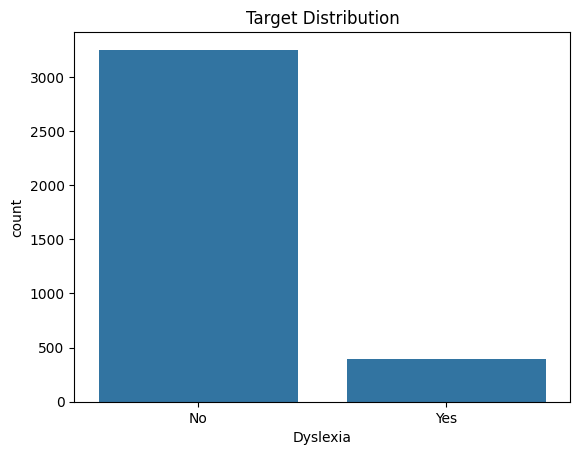


Tablet Target Distribution:
Dyslexia
No     89.390681
Yes    10.609319
Name: proportion, dtype: float64


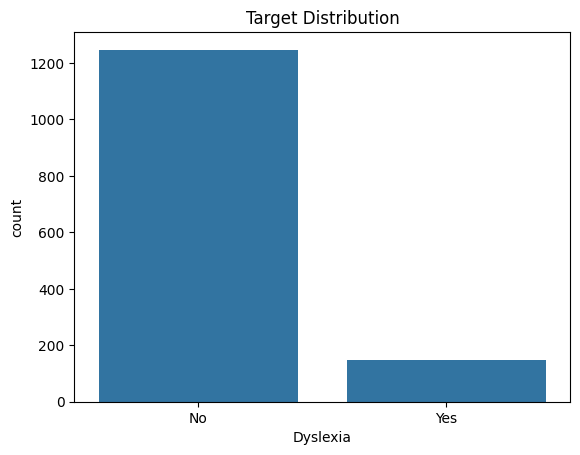

In [17]:
# Checking output label imbalance
target_column = "Dyslexia"

print("Desktop Target Distribution:")
print(f"{df_desktop[target_column].value_counts(normalize=True) * 100}")
sns.countplot(x=df_desktop[target_column])
plt.title("Target Distribution")
plt.show()
print()
print("Tablet Target Distribution:")
print(f"{df_tablet[target_column].value_counts(normalize=True) * 100}")
sns.countplot(x=df_tablet[target_column])
plt.title("Target Distribution")
plt.show()

Clearly, there is a huge imbalance in the positive and negative classes.

Stratified KFold to be used.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding categorical columns in df_desktop
categorical_cols = df_desktop.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df_desktop[col] = le.fit_transform(df_desktop[col])
df_desktop

Encoding column: Gender
Encoding column: Nativelang
Encoding column: Otherlang
Encoding column: Dyslexia


,Gender,Nativelang,Otherlang,Age,Clicks1,Hits1,Misses1,Score1,Accuracy1,Missrate1,...,Score31,Accuracy31,Missrate31,Clicks32,Hits32,Misses32,Score32,Accuracy32,Missrate32,Dyslexia
0,1,0,1,7,10,10,0,10,1.0,0.0,...,0,0.000000,0.00,17,2,0,2,0.117647,0.000000,0
1,0,1,1,13,12,12,0,12,1.0,0.0,...,4,0.114286,0.00,26,2,2,2,0.076923,0.076923,1
2,0,0,1,7,6,6,0,6,1.0,0.0,...,4,0.114286,0.00,26,1,3,1,0.038462,0.115385,0
3,0,0,1,7,0,0,0,0,0.0,0.0,...,0,0.000000,0.00,1,0,0,0,0.000000,0.000000,0
4,0,0,1,8,4,4,0,4,1.0,0.0,...,1,25.000000,0.05,26,2,2,2,0.076923,0.076923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,1,0,0,10,7,7,0,7,1.0,0.0,...,2,0.670000,0.33,4,1,3,1,0.250000,0.750000,1
3640,0,0,1,15,9,9,0,9,1.0,0.0,...,3,0.750000,0.25,4,2,2,2,0.500000,0.500000,0
3641,0,0,1,15,11,11,0,11,1.0,0.0,...,3,0.600000,0.40,4,2,2,2,0.500000,0.500000,0
3642,0,0,1,15,10,10,0,10,1.0,0.0,...,3,0.750000,0.25,4,3,1,3,0.750000,0.250000,0


In [ ]:
# Checking for duplicate rows in the df
duplicates = df_desktop.duplicated().sum()
print(f"Number of Duplicate Samples: {duplicates}")
if duplicates > 0:
    print("Dropping Duplicates...")
    df_desktop.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
else:
    print("No Duplicate Samples Found.")

Number of Duplicate Samples: 0
No Duplicate Samples Found.


In [ ]:
# Creating the training and target sets
X = df_desktop.drop("Dyslexia",axis=1)
y = df_desktop['Dyslexia']

# **PLOS One Paper "Predicting risk of dyslexia with an online gamified test" Model Replication**

In [ ]:
# Lists to store scores and predictions for the paper's model
scores_paper_accuracy = []
scores_paper_precision = []
scores_paper_recall = []
scores_paper_f1 = []

# Lists to store true labels and predicted labels for the paper's model
y_true_all = []
y_pred_paper_all = []

# Creating a Random Forest Classifier model which replicates the paper's model
model = RandomForestClassifier(n_estimators=200, max_depth = 20, max_features = 14, class_weight='balanced', random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
        # Splitting data into training and testing sets
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scaling the input datasets
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Training the model
        model.fit(X_train, y_train)
        # Get predicted probabilities
        probabilities = model.predict_proba(X_test)

        # Applying a custom threshold
        custom_threshold = 0.24
        y_pred_custom = (probabilities[:, 1] >= custom_threshold).astype(int)

        # Appending true and predicted labels for aggregation
        y_true_all.extend(y_test)
        y_pred_paper_all.extend(y_pred_custom)

        print(f"Fold: {len(scores_paper_accuracy) + 1}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_custom))
        print("\n")

        # Calculating metrics
        scores_paper_accuracy.append(accuracy_score(y_test, y_pred_custom))
        scores_paper_precision.append(precision_score(y_test, y_pred_custom, average='weighted'))
        scores_paper_recall.append(recall_score(y_test, y_pred_custom, average='weighted'))
        scores_paper_f1.append(f1_score(y_test, y_pred_custom, average='weighted'))

Fold: 1
Confusion Matrix:
[[301  25]
 [ 25  14]]


Fold: 2
Confusion Matrix:
[[310  16]
 [ 16  23]]


Fold: 3
Confusion Matrix:
[[306  19]
 [ 16  24]]


Fold: 4
Confusion Matrix:
[[306  19]
 [ 18  22]]


Fold: 5
Confusion Matrix:
[[306  19]
 [ 21  18]]


Fold: 6
Confusion Matrix:
[[305  20]
 [ 21  18]]


Fold: 7
Confusion Matrix:
[[312  13]
 [ 20  19]]


Fold: 8
Confusion Matrix:
[[315  10]
 [ 24  15]]


Fold: 9
Confusion Matrix:
[[302  23]
 [ 14  25]]


Fold: 10
Confusion Matrix:
[[310  15]
 [ 23  16]]




In [ ]:
# Printing the results
print(f"Model Accuracy: {np.mean(scores_paper_accuracy):.4f}")
print(f"Model Precision: {np.mean(scores_paper_precision):.4f}")
print(f"Model Recall: {np.mean(scores_paper_recall):.4f}")
print(f"Model F1-Score: {np.mean(scores_paper_f1):.4f}")

Model Accuracy: 0.8965
Model Precision: 0.8948
Model Recall: 0.8965
Model F1-Score: 0.8952


In [23]:
cm_aggregated = confusion_matrix(y_true_all, y_pred_paper_all)
print("Aggregated Confusion Matrix:\n", cm_aggregated)

Aggregated Confusion Matrix:
 [[3073  179]
 [ 198  194]]


In [ ]:
# Calculating class-wise metrics
classes = np.unique(y)  # List of unique class labels

for i, class_label in enumerate(classes):
    TP = cm_aggregated[i, i]  # True positives for class i
    FP = cm_aggregated[:, i].sum() - TP  # False positives for class i
    FN = cm_aggregated[i, :].sum() - TP  # False negatives for class i

    # Calculating precision, recall, and F1 score for each class
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Printing the metrics for each class
    print(f"Class {class_label}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("-" * 40)

Class 0:
  Precision: 0.94
  Recall: 0.94
  F1 Score: 0.94
----------------------------------------
Class 1:
  Precision: 0.52
  Recall: 0.49
  F1 Score: 0.51
----------------------------------------


# **Self-Model Implementation**

## **Individual Model Comparison**

In [25]:
classes, samples_in_class = np.unique(y, return_counts=True)
n_classes = len(classes)
total_samples = len(y)
class_weights = [total_samples / (n_classes * count) for count in samples_in_class]
class_weights_dict = {i: class_weights[i] for i in range(n_classes)}

negative_samples = samples_in_class[0]  # Count of class 0
positive_samples = samples_in_class[1]  # Count of class 1

scale_pos_weight = negative_samples / positive_samples

### **Finding Best k-Value for KNN**

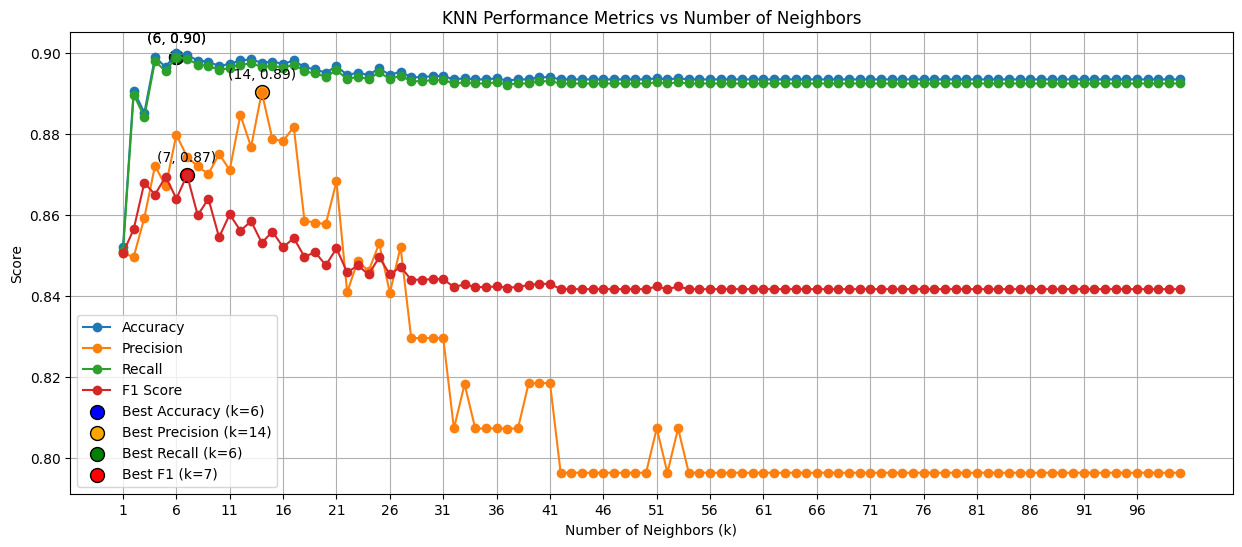

In [ ]:
# Finding the best k value for KNN
neighbors_range = list(range(1, 101)) # Range of k values from 1 to 100

# Lists to store mean scores for each metric
mean_accuracies = []
mean_precisions = []
mean_recalls = []
mean_f1s = []

# Looping through each k value and calculating the metrics
for k_neighbors in neighbors_range:
    KNN = KNeighborsClassifier(n_neighbors=k_neighbors, metric='minkowski', p=1) # Using Manhattan distance (p=1) (Replace with p=2 for Euclidean distance)
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f1 = []

    # Using 10-fold Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        KNN.fit(X_train, y_train)
        y_pred = KNN.predict(X_test)

        scores_accuracy.append(accuracy_score(y_test, y_pred))
        scores_precision.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        scores_recall.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        scores_f1.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    
    mean_accuracies.append(np.mean(scores_accuracy))
    mean_precisions.append(np.mean(scores_precision))
    mean_recalls.append(np.mean(scores_recall))
    mean_f1s.append(np.mean(scores_f1))

# Calculating the best k values for each metric
best_k_acc = neighbors_range[np.argmax(mean_accuracies)]
best_k_prec = neighbors_range[np.argmax(mean_precisions)]
best_k_recall = neighbors_range[np.argmax(mean_recalls)]
best_k_f1 = neighbors_range[np.argmax(mean_f1s)]

# Plotting the k values against the metrics and highlighting the best k values
plt.figure(figsize=(15, 6))
plt.plot(neighbors_range[:len(mean_accuracies)], [val + 0.001 for val in mean_recalls], label='Accuracy', marker='o')
plt.plot(neighbors_range[:len(mean_precisions)], mean_precisions, label='Precision', marker='o')
plt.plot(neighbors_range[:len(mean_recalls)], mean_recalls, label='Recall', marker='o')
plt.plot(neighbors_range[:len(mean_f1s)], mean_f1s, label='F1 Score', marker='o')

plt.scatter(best_k_acc, mean_accuracies[best_k_acc - 1], color='blue', s=100, edgecolor='black', label=f'Best Accuracy (k={best_k_acc})')
plt.annotate(f"({best_k_acc}, {mean_accuracies[best_k_acc - 1]:.2f})",
             (best_k_acc, mean_accuracies[best_k_acc - 1]),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.scatter(best_k_prec, mean_precisions[best_k_prec - 1], color='orange', s=100, edgecolor='black', label=f'Best Precision (k={best_k_prec})')
plt.annotate(f"({best_k_prec}, {mean_precisions[best_k_prec - 1]:.2f})",
             (best_k_prec, mean_precisions[best_k_prec - 1]),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.scatter(best_k_recall, mean_recalls[best_k_recall - 1], color='green', s=100, edgecolor='black', label=f'Best Recall (k={best_k_recall})')
plt.annotate(f"({best_k_recall}, {mean_recalls[best_k_recall - 1]:.2f})",
             (best_k_recall, mean_recalls[best_k_recall - 1]),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.scatter(best_k_f1, mean_f1s[best_k_f1 - 1], color='red', s=100, edgecolor='black', label=f'Best F1 (k={best_k_f1})')
plt.annotate(f"({best_k_f1}, {mean_f1s[best_k_f1 - 1]:.2f})",
             (best_k_f1, mean_f1s[best_k_f1 - 1]),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('KNN Performance Metrics vs Number of Neighbors')
plt.xticks(np.arange(1, 101, 5))
plt.legend()
plt.grid(True)
plt.show() 

**Metrics vs k-Values (Euclidean Distance) Plot**

<img src="../Plots & Visuals/euclidean.png" alt="Metrics vs k-Values (Euclidean Distance)" style="width: 1000px; height: 450px"/>

**Metrics vs k-Values (Manhattan Distance) Plot**

<img src="../Plots & Visuals/manhattan.png" alt="Metrics vs k-Values (Manhattan Distance)" style="width: 1000px; height: 450px"/>

### **Models Comparison**

In [ ]:
# All the models to be trained for baseline comparison
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth = 20, max_features = 20, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=10_000, class_weight='balanced', random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=1),
    "Gradient Boosting": HistGradientBoostingClassifier(class_weight=class_weights_dict, random_state=42),
    "Bagging Classifier": BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42),
    "XGBoost Classifier": XGBClassifier(verbosity=0, scale_pos_weight=scale_pos_weight, random_state=42),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, class_weights = class_weights, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42),
}

# Dictionaries to store true and predicted labels for each model
y_true_all = {model_name: [] for model_name in models.keys()}
y_pred_all = {model_name: [] for model_name in models.keys()}

# Looping through each model, training it, and evaluating its performance
for model_name, model in models.items():
  # Lists to store scores for each metric
  scores_accuracy = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []

  # Creating a Stratified K-Fold cross-validation object for 10-folds
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  for train_index, test_index in skf.split(X, y):
          # Splitting data into training and testing sets
          X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]

          # Scaling the input datasets
          scaler = StandardScaler()
          X_train = scaler.fit_transform(X_train)
          X_test = scaler.transform(X_test)

          # Training the model
          model.fit(X_train, y_train)

          # Special case for Random Forest to predict probabilities
          if model_name == "Random Forest":
            # Predict probabilities for Random Forest
            y_prob = model.predict_proba(X_test)
            y_pred = (y_prob[:, 1] >= 0.24).astype(int)

          else:
              # Predicting on the test set
              y_pred = model.predict(X_test)

          # Appending true and predicted labels for aggregation
          y_true_all[model_name].extend(y_test)
          y_pred_all[model_name].extend(y_pred)

          # Calculating metrics
          scores_accuracy.append(accuracy_score(y_test, y_pred))
          scores_precision.append(precision_score(y_test, y_pred, average='weighted'))
          scores_recall.append(recall_score(y_test, y_pred, average='weighted'))
          scores_f1.append(f1_score(y_test, y_pred, average='weighted'))

  # Printing the results
  print(f"{model_name} Accuracy: {np.mean(scores_accuracy):.4f}")
  print(f"{model_name} Precision: {np.mean(scores_precision):.4f}")
  print(f"{model_name} Recall: {np.mean(scores_recall):.4f}")
  print(f"{model_name} F1-Score: {np.mean(scores_f1):.4f}")
  print("\n")

Random Forest Accuracy: 0.8946
Random Forest Precision: 0.8966
Random Forest Recall: 0.8946
Random Forest F1-Score: 0.8952


Logistic Regression Accuracy: 0.8008
Logistic Regression Precision: 0.8937
Logistic Regression Recall: 0.8008
Logistic Regression F1-Score: 0.8319


Support Vector Machine Accuracy: 0.8466
Support Vector Machine Precision: 0.8952
Support Vector Machine Recall: 0.8466
Support Vector Machine F1-Score: 0.8644


KNN Accuracy: 0.8985
KNN Precision: 0.8743
KNN Recall: 0.8985
KNN F1-Score: 0.8698


Gradient Boosting Accuracy: 0.9081
Gradient Boosting Precision: 0.9033
Gradient Boosting Recall: 0.9081
Gradient Boosting F1-Score: 0.9045


Bagging Classifier Accuracy: 0.8963
Bagging Classifier Precision: 0.8723
Bagging Classifier Recall: 0.8963
Bagging Classifier F1-Score: 0.8733


XGBoost Classifier Accuracy: 0.9081
XGBoost Classifier Precision: 0.8974
XGBoost Classifier Recall: 0.9081
XGBoost Classifier F1-Score: 0.8997


CatBoost Classifier Accuracy: 0.9045
CatBoost Cla

In [ ]:
# Printing aggregated confusion matrices and class-wise metrics for each model
for model_name, model in models.items():
  cm_aggregated = confusion_matrix(y_true_all[model_name], y_pred_all[model_name])
  print(f"{model_name} Confusion Matrix:\n", cm_aggregated)
  print("\n")

  # Calculating class-wise metrics
  classes = np.unique(y)  # List of unique class labels

  for i, class_label in enumerate(classes):
      TP = cm_aggregated[i, i]  # True positives for class i
      FP = cm_aggregated[:, i].sum() - TP  # False positives for class i
      FN = cm_aggregated[i, :].sum() - TP  # False negatives for class i

      # Calculating precision, recall, and F1 score for each class
      precision = TP / (TP + FP) if (TP + FP) != 0 else 0
      recall = TP / (TP + FN) if (TP + FN) != 0 else 0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

      # Printing the metrics for each class
      print(f"Class {class_label}:")
      print(f"  Precision: {precision:.4f}")
      print(f"  Recall: {recall:.4f}")
      print(f"  F1 Score: {f1:.4f}")
      print("-" * 40)
  print("\n")

Random Forest Confusion Matrix:
 [[3053  199]
 [ 185  207]]


Class 0:
  Precision: 0.9429
  Recall: 0.9388
  F1 Score: 0.9408
----------------------------------------
Class 1:
  Precision: 0.5099
  Recall: 0.5281
  F1 Score: 0.5188
----------------------------------------


Logistic Regression Confusion Matrix:
 [[2627  625]
 [ 101  291]]


Class 0:
  Precision: 0.9630
  Recall: 0.8078
  F1 Score: 0.8786
----------------------------------------
Class 1:
  Precision: 0.3177
  Recall: 0.7423
  F1 Score: 0.4450
----------------------------------------


Support Vector Machine Confusion Matrix:
 [[2820  432]
 [ 127  265]]


Class 0:
  Precision: 0.9569
  Recall: 0.8672
  F1 Score: 0.9098
----------------------------------------
Class 1:
  Precision: 0.3802
  Recall: 0.6760
  F1 Score: 0.4867
----------------------------------------


KNN Confusion Matrix:
 [[3214   38]
 [ 332   60]]


Class 0:
  Precision: 0.9064
  Recall: 0.9883
  F1 Score: 0.9456
----------------------------------------